## Analisis Penjualan dan Pengiriman pada Ecommerce

Objctive:
- Kota mana sajakah yang memiliki transaksi paling banyak?
- Kota mana sajakah dengan pengiriman terlambat terbanyak?
- Bagaimana pengaruh keterlambatan pengiriman terhadap review?



### Import Library

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Import Data

In [2]:
def get_result(query):
    '''
    Querying olist database

    Parameter
    ---------
    query : 'string'
        the query to get the data from database

    Returns 
    -------
    List of data
    '''
    conn = sqlite3.connect('/content/drive/MyDrive/Pacmann AI/Data Wrangling & SQL/olist.db')
    cursor = conn.cursor()
    cursor.execute(query)
    data = cursor.fetchall()
    conn.close()
    return data

def create_db(data, columns):
    '''
    Convert list of data into dataframe

    Parameter
    ---------
    data : 'list'
        list of data
    columns : 'list'
        list of column name

    Returns 
    -------
    dataframe
    '''
    return pd.DataFrame(data=data, columns=columns).drop(['index'], axis=1)

In [3]:
# extract table order
order = create_db(get_result('SELECT * FROM olist_order_dataset'), ['index','order_id','customer_id','order_status','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'])
# extract table customer
customer = create_db(get_result('SELECT * FROM olist_order_customer_dataset'), ['index', 'customer_id','customers_unique_id','customers_zip_code_prefix','customer_city','customer_state'])
# extract table review
review = create_db(get_result('SELECT * FROM olist_order_reviews_dataset'), ['index','review_id', 'order_id','review_score','review_comment_title','review_comment_message','review_creation_date','review_answer_timestamp'])

### Data Preprocessing

#### Missing Value

In [4]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


Terdapat missing value pada kolom order_approved_at, order_delivered_carrier_date, dan order_delivered_customer_date. Hal ini terjadi karena terdapat berbagai macam status order. Dalam analisis ini hanya akan dilakukan analisis terhadap order dengan status 'delivered'.

In [5]:
# filter delivered transaction
order_delivered = order[order['order_status']=='delivered'].copy()
order_delivered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96478 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96478 non-null  object
 1   customer_id                    96478 non-null  object
 2   order_status                   96478 non-null  object
 3   order_purchase_timestamp       96478 non-null  object
 4   order_approved_at              96464 non-null  object
 5   order_delivered_carrier_date   96476 non-null  object
 6   order_delivered_customer_date  96470 non-null  object
 7   order_estimated_delivery_date  96478 non-null  object
dtypes: object(8)
memory usage: 6.6+ MB


Ternyata masih terdapat missing value pada kolom order_approved_at, order_delivered_carrier_date, dan order_delivered_customer_date meskipun status ordernya sudah terkirim. Hal ini cukup aneh dan bisa kita asumsikan ini disebabkan oleh kesalahan sistem. Mengingat jumlah missing value tidak terlalu banyak maka row yang mengandung missing value akan dihapus.

In [6]:
# drop row with missing value 
order_delivered.dropna(inplace=True)

In [7]:
order_delivered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96455 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96455 non-null  object
 1   customer_id                    96455 non-null  object
 2   order_status                   96455 non-null  object
 3   order_purchase_timestamp       96455 non-null  object
 4   order_approved_at              96455 non-null  object
 5   order_delivered_carrier_date   96455 non-null  object
 6   order_delivered_customer_date  96455 non-null  object
 7   order_estimated_delivery_date  96455 non-null  object
dtypes: object(8)
memory usage: 6.6+ MB


In [8]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   customer_id                99441 non-null  object
 1   customers_unique_id        99441 non-null  object
 2   customers_zip_code_prefix  99441 non-null  int64 
 3   customer_city              99441 non-null  object
 4   customer_state             99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [9]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


Terdapat missing value pada kolom review_comment_title dan review_comment_message. Hal ini wajar terjadi karena komentar pada review biasanya bersifat opsional sehingga missing value tidak perlu ditangani.

#### Duplicate

In [10]:
# check duplicate in order table
order_delivered[order_delivered.duplicated(subset='order_id')]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [11]:
# check duplicate in customer table
customer[customer.duplicated(subset='customer_id')]

,customer_id,customers_unique_id,customers_zip_code_prefix,customer_city,customer_state


In [12]:
# check duplicate in review table
review[review.duplicated(subset='order_id')]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
1119,46abf3ea0b2710ad41390fdb79c32d84,5040757d4e06a4be96d3827b860b4e7c,5,None,None,2017-11-07 00:00:00,2017-11-10 20:07:48
3109,aa193e76d35950c4ae988237bb36ed2b,cf73e2cb1f4a9480ed70c154da3d954a,5,None,None,2018-01-18 00:00:00,2018-01-18 17:36:45
8108,40294ea5a778dc62080d6b3f55d361ce,e1bc1083cd7acd30d0576335373b907d,5,None,None,2018-03-23 00:00:00,2018-03-24 00:23:06
9064,32e2c7e889f7a185d462265398ee3631,c7cfea0c153e6382e32e84c2a9dd7d2e,5,None,None,2017-10-21 00:00:00,2017-10-22 00:47:25
9795,95a3135743556b117d888cc8c6e12e11,f9c78e6e58306dc81efbbada1ac11f24,3,None,O produto chegou antes do prazo mas recebi um ...,2017-09-14 00:00:00,2017-09-17 11:14:08
...,...,...,...,...,...,...,...
98989,dfb3db02188d809d5cd199496b6da87e,c0db7d31ace61fc360a3eaa34dd3457c,5,None,None,2018-02-17 00:00:00,2018-02-19 19:29:19
99108,2c6c08892b83ba4c1be33037c2842294,42ae1967f68c90bb325783ac55d761ce,4,None,"Chegou um pouco amassada, mas nada de mais, e ...",2017-07-03 00:00:00,2017-07-05 19:06:59
99164,2afe63a67dfd99b3038f568fb47ee761,c5334d330e36d2a810a7a13c72e135ee,5,None,"Muito bom, produto conforme anunciado, entrega...",2018-03-03 00:00:00,2018-03-04 22:56:47
99178,44d1e9165ec54b1d89d33594856af859,a7dbcf5043158d6fa72859eead2f3d10,4,None,None,2017-05-24 00:00:00,2017-05-24 23:15:21


Terdapat duplicate pada data review

In [13]:
# check an order_id
review[review.order_id=='5040757d4e06a4be96d3827b860b4e7c']

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
1028,afd9b3d196f0acd81d79d8ccd79c2430,5040757d4e06a4be96d3827b860b4e7c,5,None,None,2017-10-31 00:00:00,2017-11-04 21:12:29
1119,46abf3ea0b2710ad41390fdb79c32d84,5040757d4e06a4be96d3827b860b4e7c,5,None,None,2017-11-07 00:00:00,2017-11-10 20:07:48


Duplikasi terjadi karena survei kepuasan dikirimkan dua kali. Untuk menanganinnya akan diambil review dengan jawaban terakhir.

In [14]:
# remove duplicate in review table
review = review.sort_values('review_answer_timestamp').drop_duplicates(subset='order_id', keep='last')

#### join data

In [15]:
# join order, customer, and review table
order_customer = order_delivered.merge(customer, left_on='customer_id', right_on='customer_id', how='left')
df = order_customer.merge(review, left_on='order_id', right_on='order_id', how='left')

# filter columns that will be used
df = df[['order_id','customer_id','order_status','order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date','customers_unique_id','customer_city','customer_state','review_score']]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96455 entries, 0 to 96454
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       96455 non-null  object 
 1   customer_id                    96455 non-null  object 
 2   order_status                   96455 non-null  object 
 3   order_purchase_timestamp       96455 non-null  object 
 4   order_delivered_customer_date  96455 non-null  object 
 5   order_estimated_delivery_date  96455 non-null  object 
 6   customers_unique_id            96455 non-null  object 
 7   customer_city                  96455 non-null  object 
 8   customer_state                 96455 non-null  object 
 9   review_score                   95809 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.1+ MB


### Analysis

#### Kota dengan transaksi terbanyak

In [17]:
# calculate top 10 city with the most transaction
num_order_city = df.groupby('customer_city')['order_id'].nunique().sort_values(ascending=False).head(10).reset_index()

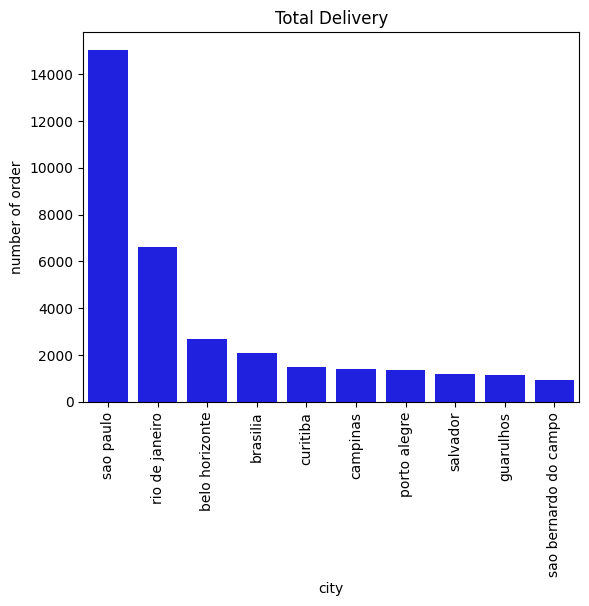

In [18]:
sns.barplot(data=num_order_city, x='customer_city', y='order_id', color='blue')
plt.xlabel('city')
plt.ylabel('number of order')
plt.title('Total Delivery')
plt.xticks(rotation=90)
plt.show()

Transaksi di dominasi oleh kota sao paulo. Bahkan total transaksi di kota sao paulo lebih dari 2 kali rio de janeiro yang merupakan kota kedua dengan transaksi paling banyak.

#### Kota dengan transaksi yang dikirimkan terlambat paling banyak

In [19]:
# calculate top 10 city with the most late delivered transaction
df['is_late']=df.order_estimated_delivery_date<df.order_delivered_customer_date
df_late = df[df.is_late]
num_order_late_delivery = df_late.groupby('customer_city')['order_id'].nunique().sort_values(ascending=False).head(10).reset_index()

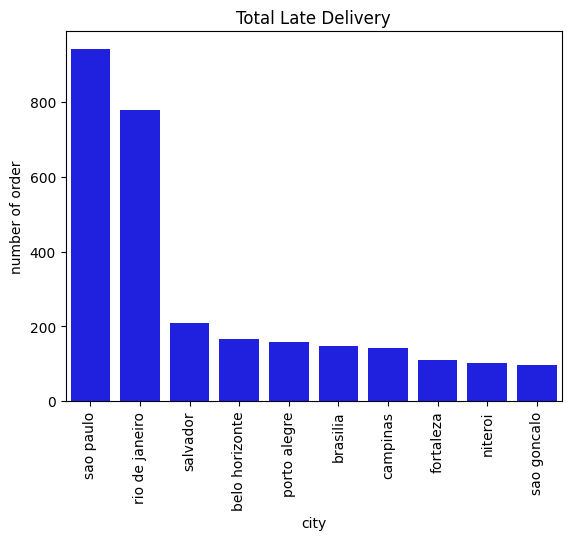

In [20]:
sns.barplot(data=num_order_late_delivery, x='customer_city', y='order_id', color='blue')
plt.xlabel('city')
plt.ylabel('number of order')
plt.title('Total Late Delivery')
plt.xticks(rotation=90)
plt.show()

kota sao paulo dan rio de janeiro memiliki total pengiriman terlambat paling banyak. Hal ini sejalan dengan total transaksi yang ada pada kota tersebut.

#### Perngaruh keterlambatan pengiriman dengan review

In [21]:
# calculate the comparison of late delivery and review_score
late_vs_review=pd.crosstab(df.is_late,df.review_score)
# calculate the percentage
late_vs_review_pct = late_vs_review.div(late_vs_review.sum(axis=1),axis=0)
late_vs_review_pct

review_score,1.0,2.0,3.0,4.0,5.0
is_late,,,,,
False,0.065922,0.026296,0.079899,0.203519,0.624363
True,0.462141,0.078590,0.113838,0.123238,0.222193


Transaksi dengan pengiriman yang terlambat akan cenderung mendapatkan rating 1. Sebanyak 46% transaksi dengan pengiriman terlambat mendapatkan rating 1. Sementara, transaksi dengan pengiriman tepat waktu cenderung mendapatkan rating 5. Sebanyak 62% transaksi dengan pengiriman tepat waktu mendapatkan rating 5.

### Rekomendasi

Untuk menjaga kepuasan konsumen disarankan untuk meningkatkan kualitas pengiriman mengingat konsumen cenderung memberikan rating 1 apabila barang dikirimkan terlambat. Kota dengan jumlah transaksi tinggi seperti Sao Paulo dan Rio De Janeiro memiliki kemungkinan keterlambatan pengiriman lebih banyak sehingga disarankan untuk menambah armada pengiriman di kota-kota ini.